In [1]:
!git clone -l -s https://github.com/Crash-Analysis-Chicago/Chicago.git

Cloning into 'Chicago'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 48 (delta 13), reused 20 (delta 4), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Libraries: Standard ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for boxplots
import seaborn as sns

# K-means function
from sklearn.cluster import KMeans

# Functions for silhouette
from sklearn.metrics import silhouette_samples, silhouette_score

# Function to standardize the data 
from sklearn.preprocessing import scale

# Functions for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from mpl_toolkits.mplot3d import Axes3D

In [4]:
tabl=pd.read_csv("/content/drive/My Drive/IMT Atlantique 2A/Colab Notebooks/chicago_crashes_cleaned_32.csv", sep=",")

tabl.head()

,Unnamed: 0,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ROADWAY_SURFACE_COND,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,LATITUDE,LONGITUDE,CRASH_WEEKDAY,CRASH_HOUR,CRASH_Month,grid
0,3,2017-06-30 16:00:00,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,DRY,INJURY AND / OR TOW DUE TO CRASH,Y,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,8301,S,CICERO AVE,41.741804,-87.740954,4,16,6,"(10.0, 8.0)"
1,4,2019-03-21 22:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,DRY,NO INJURY / DRIVE AWAY,Y,NaN,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,8301,S,CICERO AVE,41.741804,-87.740954,3,22,3,"(10.0, 8.0)"
2,5,2018-03-26 14:23:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO INJURY / DRIVE AWAY,NaN,NaN,"$501 - $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,3999,N,AVONDALE AVE,41.953647,-87.732082,0,14,3,"(11.0, 26.0)"
3,6,2018-08-30 17:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,DRY,NO INJURY / DRIVE AWAY,Y,NaN,"OVER $1,500",IMPROPER OVERTAKING/PASSING,IMPROPER LANE USAGE,600,W,DIVISION ST,41.903825,-87.643286,3,17,8,"(19.0, 22.0)"
4,7,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,DRY,NO INJURY / DRIVE AWAY,Y,NaN,"$501 - $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,41.794779,-87.623828,1,8,6,"(21.0, 12.0)"


In [5]:
tabl['grid'].replace('', np.nan, inplace=True)
tabl.dropna(axis=0, subset=['grid'], inplace=True)

On traduit le texte définissant la grille en 2 coordonnées x et y.

In [6]:
lst = tabl['grid'].tolist()
lst = [i.replace('(','').replace(')','').split(sep=',') for i in lst]
lst = [[float(i[0]), float(i[1])] for i in lst]
lst = np.array(lst)
tabl['x']= lst[:,0]
tabl['y']= lst[:,1]

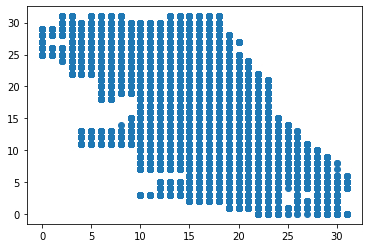

In [7]:
plt.scatter(lst[:,0],lst[:,1])

On remarque qu'une grande partie des accidents implique des dégats matériels d'une valeur de plus de 1500$.

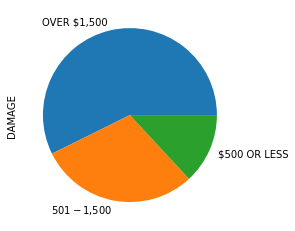

In [36]:

tabl.DAMAGE.value_counts().plot.pie()

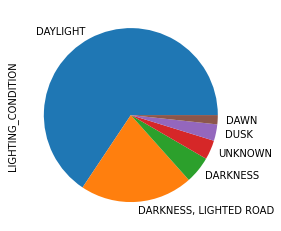

In [37]:
tabl.LIGHTING_CONDITION.value_counts().plot.pie()


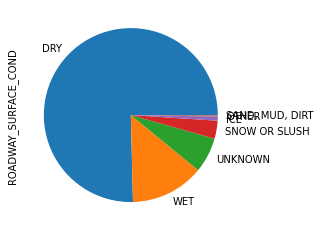

In [38]:
tabl.ROADWAY_SURFACE_COND.value_counts().plot.pie()

In [11]:
tabl.PRIM_CONTRIBUTORY_CAUSE.value_counts()

UNABLE TO DETERMINE                                                                 162259
FAILING TO YIELD RIGHT-OF-WAY                                                        49240
FOLLOWING TOO CLOSELY                                                                47775
NOT APPLICABLE                                                                       23842
IMPROPER OVERTAKING/PASSING                                                          21230
IMPROPER BACKING                                                                     19642
FAILING TO REDUCE SPEED TO AVOID CRASH                                               18956
IMPROPER LANE USAGE                                                                  17378
IMPROPER TURNING/NO SIGNAL                                                           14874
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  13801
DISREGARDING TRAFFIC SIGNALS                                                          7836

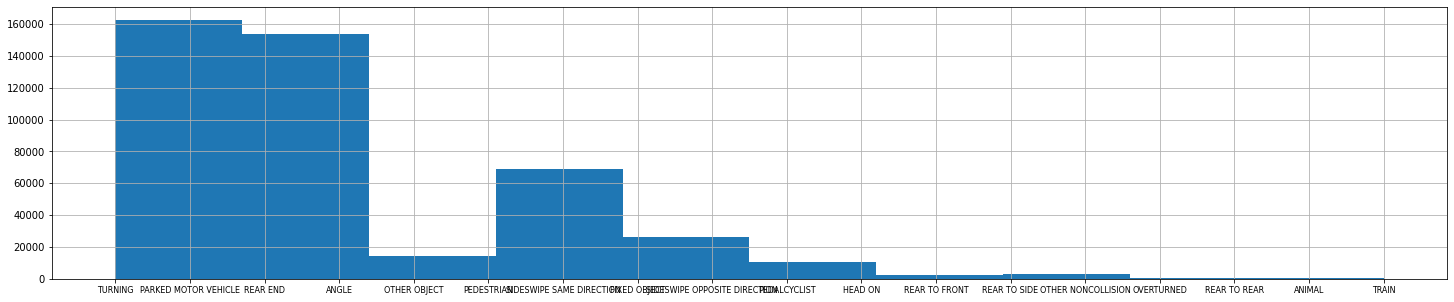

In [12]:
tabl.FIRST_CRASH_TYPE.hist(figsize=(25,5), xlabelsize=8)

J'ai tracé la courbe du nombre d'accidents par heures sur une durée d'une semaine. On retrouve bien les départs au travail entre 7 et 9h qui correspondent à un pic d'accident. Il y a un deuxième pic de 14 à 16h, ce qui correspond au retour du travail et aux déplacements liés aux activités des habitants de Chicago. Le week-end, on retrouve seulement un pic d'accidents vers le milieu de la journée car la plupart des habitants ne se déplacent pas le matin. On remarque une légère hausse des accidents les vendredi et samedi soir, ce qui peut être expliqué par les individus allant et rentrant en soirée. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a5e7262b0>,
      dtype=object)

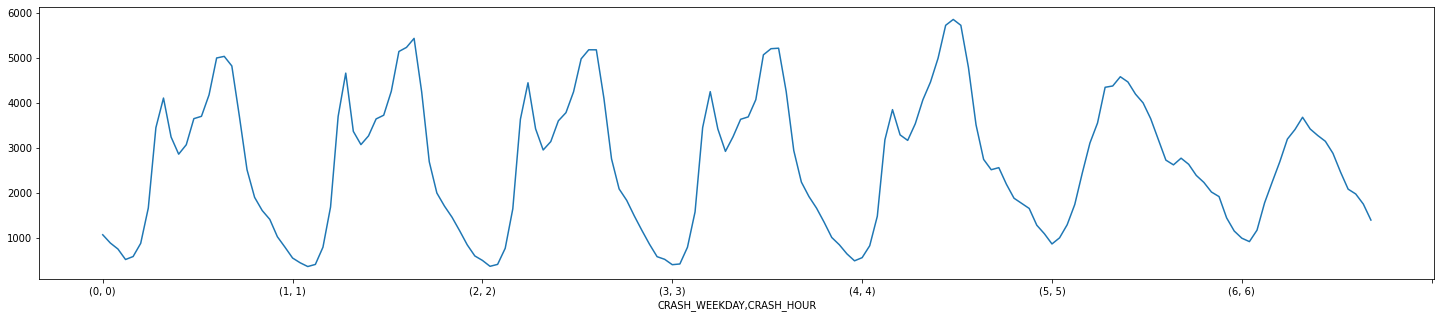

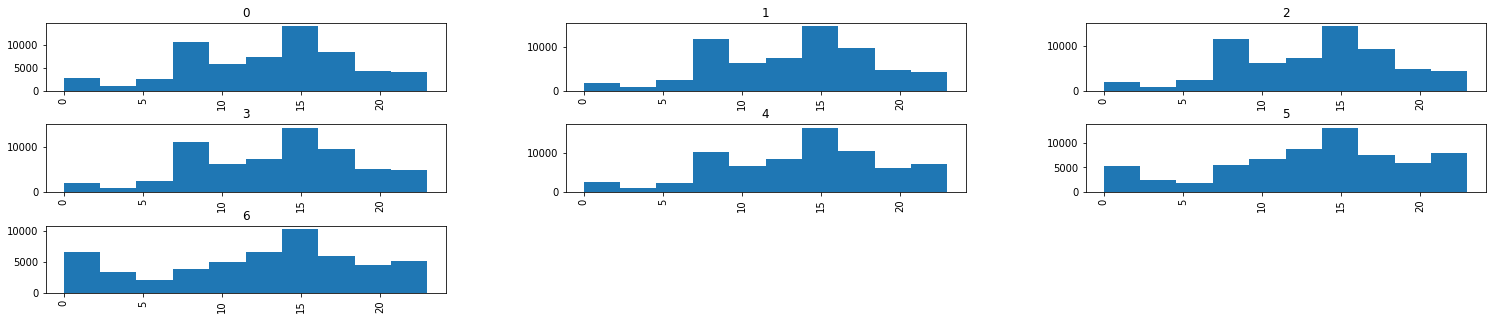

In [13]:
tabl['compte']=1
tabl.groupby(['CRASH_WEEKDAY', 'CRASH_HOUR']).count().compte.plot(figsize=(25,5))
tabl.CRASH_HOUR.plot(by=tabl.CRASH_WEEKDAY,figsize=(25,5))

Ici, j'ai affiché le nombre d'accidents par heures de la journée pour chaques mois de l'année. On retrouve sur l'année la même logique que celle que l'on a trouvé sur les jours de la semaine. En juin, juillet et août, les américains partent en vacances donc le nombre d'accidents augmentent au cours de la journée jusqu'à 15h, puis redescent en même temps que l'activité de la ville diminue. Durant les autres mois, un nombre beaucoup plus grand de personnes vont travailler chaques jours donc on observe bien des pics d'accidents que l'on peut associer aux départs. Le pic de l'après-midi est légèrements décallé vers une horaire plus tardive car les employés rentrent du travail de 15h à 18h.

De manière plus globale, on observe qu'il y a plus d'accidents durant les mois les plus ensoleillés, peut-être car les habitants de Chicago préfèrent sortir quand il y a encore du soleil.

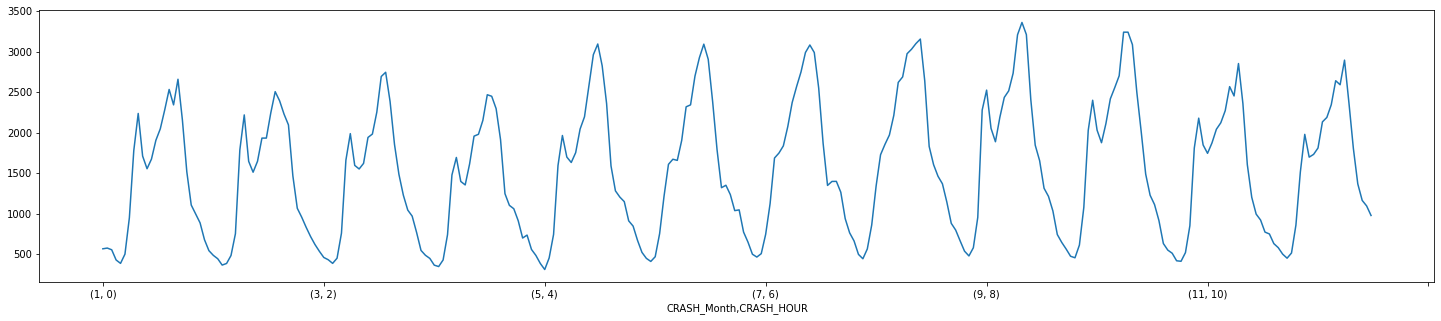

In [14]:
tabl['compte']=1
tabl.groupby(['CRASH_Month', 'CRASH_HOUR']).count().compte.plot(figsize=(25,5))

On voit que même si des accidents se produisent dans beaucoup de reus différentes, seulement une petite quantité d'entre elle en acceuillent une majorité. Il y a égalements des zones de la ville dans lesquelles se produisent beaucoup plus d'accidents que dans d'autres?

In [40]:
(tabl.STREET_NAME.value_counts()/442645)
(tabl.STREET_NAME.value_counts()/442645).describe()

count    1496.000000
mean        0.000668
std         0.002032
min         0.000002
25%         0.000016
50%         0.000084
75%         0.000419
max         0.027227
Name: STREET_NAME, dtype: float64

In [19]:
streetDanger = tabl[tabl['grid']== '(21.0, 21.0)'].STREET_NAME.unique()
print(tabl.STREET_NAME.value_counts())
tabl[tabl['STREET_NAME'].isin(streetDanger)].STREET_NAME.value_counts()


WESTERN AVE    12052
PULASKI RD     10675
CICERO AVE      9756
ASHLAND AVE     9601
HALSTED ST      8564
               ...  
BRIGHTON PL        1
HARTLAND CT        1
I57 EXPY OB        1
LIANO AVE          1
GLENROY AVE        1
Name: STREET_NAME, Length: 1496, dtype: int64


MICHIGAN AVE             6070
STATE ST                 5398
CLARK ST                 5077
GRAND AVE                4642
CHICAGO AVE              4020
WABASH AVE               2003
OHIO ST                  1328
ONTARIO ST               1319
DEARBORN ST              1280
HURON ST                  772
ERIE ST                   722
ILLINOIS ST               682
HUBBARD ST                649
KINZIE ST                 522
SUPERIOR ST               447
RUSH ST                   351
OAK ST                    340
WALTON ST                 308
CHESTNUT ST               239
DELAWARE PL               224
LOWER MICHIGAN AVE        198
ST CLAIR ST               176
PEARSON ST                132
NORTH WATER ST             59
MIES VAN DER ROHE WAY      37
LOWER ILLINOIS ST          17
LOWER NORTH WATER ST       16
CITY FRONT PLAZA DR        15
LOWER WABASH AVE            5
TOWER CT                    3
LOWER HUBBARD ST            1
Name: STREET_NAME, dtype: int64

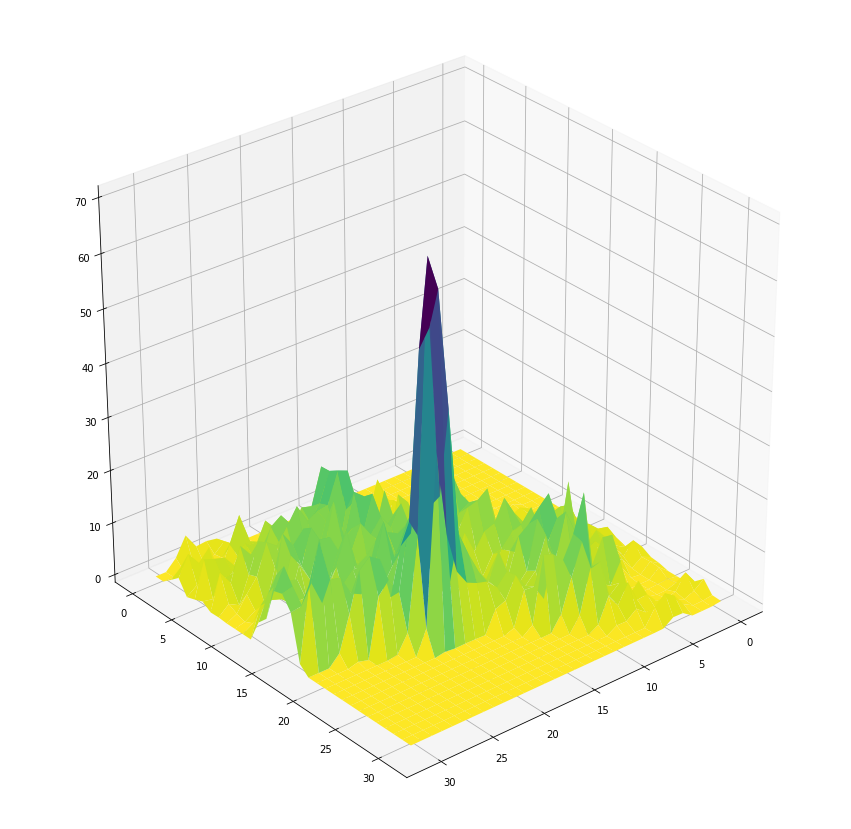

In [30]:
import matplotlib.cm as cm
test = tabl.groupby(['x','y']).count().compte
test = test.unstack()
test = test.fillna(0)
x = [i for i in range(32)]
y = [i for i in range(32)]

pos = np.zeros((32,32))


for i in x:
  for j in y:
    pos[j,i]=test[i][j]/100

x,y=np.meshgrid(x,y)

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, pos, cmap=cm.viridis_r)
ax.view_init(elev=30, azim=50)

On voit bien que les coordonnées x et y de la grille sont très corrélées avec la longitude et la latitude, comme attendu.

In [31]:
tabl.corr()

,Unnamed: 0,POSTED_SPEED_LIMIT,STREET_NO,LATITUDE,LONGITUDE,CRASH_WEEKDAY,CRASH_HOUR,CRASH_Month,x,y,compte
Unnamed: 0,1.000000,-0.002179,-0.008989,0.011795,0.002554,-0.004048,-0.003461,-0.047612,0.002599,0.011809,NaN
POSTED_SPEED_LIMIT,-0.002179,1.000000,-0.029932,0.019129,0.011426,0.003839,0.019059,0.009638,0.010926,0.018980,NaN
STREET_NO,-0.008989,-0.029932,1.000000,-0.320348,-0.075720,0.001492,0.004984,0.002205,-0.076375,-0.320238,NaN
LATITUDE,0.011795,0.019129,-0.320348,1.000000,-0.463454,-0.008558,0.000437,0.002438,-0.459157,0.999218,NaN
LONGITUDE,0.002554,0.011426,-0.075720,-0.463454,1.000000,0.003053,0.010715,-0.001447,0.998800,-0.462670,NaN
CRASH_WEEKDAY,-0.004048,0.003839,0.001492,-0.008558,0.003053,1.000000,-0.011056,0.007595,0.003164,-0.008545,NaN
CRASH_HOUR,-0.003461,0.019059,0.004984,0.000437,0.010715,-0.011056,1.000000,0.004648,0.010386,0.000539,NaN
CRASH_Month,-0.047612,0.009638,0.002205,0.002438,-0.001447,0.007595,0.004648,1.000000,-0.001432,0.002338,NaN
x,0.002599,0.010926,-0.076375,-0.459157,0.998800,0.003164,0.010386,-0.001432,1.000000,-0.458374,NaN
y,0.011809,0.018980,-0.320238,0.999218,-0.462670,-0.008545,0.000539,0.002338,-0.458374,1.000000,NaN
